In [46]:
import os
import argparse
import numpy as np
import pandas as pd
import nibabel as nib
import vtk
import math
import sys
sys.path.append('../..')
from utils.cardiac_utils import atrium_pass_quality_control, evaluate_atrial_area_length

In [29]:
# An affine array tells you the position of the image array data in a reference space.
sa_name = '/work/users/y/u/yuukias/Heart_pipeline/data/test/1000033/sa.nii.gz'
nim_sa = nib.load(sa_name)
long_axis = nim_sa.affine[:3, 2] / np.linalg.norm(nim_sa.affine[:3, 2])  # third row of affine matrix
print(long_axis)

[-0.65342208  0.5901374  -0.47410699]


## The scanner axes
The origin of the axes is at the magnet isocenter. This is coordinate (0, 0, 0) in our reference space. All three axes pass through the isocenter.

The units for all three axes are millimeters.

Imagine an observer standing behind the scanner looking through the magnet bore towards the end of the scanner bed. Imagine a line traveling towards the observer through the center of the magnet bore, parallel to the bed, with the zero point at the magnet isocenter, and positive values closer to the observer. Call this line the **scanner-bore axis**.

Draw a line traveling from the scanner room floor up through the magnet isocenter towards the ceiling, at right angles to the scanner bore axis. 0 is at isocenter and positive values are towards the ceiling. Call this the **scanner-floor/ceiling axis**.

Draw a line at right angles to the other two lines, traveling from the observer’s left, parallel to the floor, and through the magnet isocenter to the observer’s right. 0 is at isocenter and positive values are to the right. Call this the **scanner-left/right**.


## Affine Array

The voxel coordinate tells us almost nothing about where the data came from in terms of position in the scanner. For example, let’s say we have the voxel coordinate (26, 30, 16). Without more information we have no idea whether this voxel position is on the left or right of the brain, or came from the left or right of the scanner.
This is because the scanner allows us to collect voxel data in almost any arbitrary position and orientation within the magnet.

We solve this problem by keeping track of the relationship of voxel coordinates to some reference space. In particular, the **`affine` array stores the relationship between voxel coordinates in the image data array and coordinates in the reference space**.

In general, we have some voxel space coordinate $(i,j,k)$, and we want to generate the reference space coordinate $(x,y,z)$.

Imagine we had solved this, and we had a coordinate transform function $f$ that accepts a voxel coordinate and returns a coordinate in the reference space: $(x,y,z)=f(i,j,k)$, $f$ accepts a coordinate in the input space and returns a coordinate in the output space. In our case the input space is voxel space and the output space is scanner RAS+.

In theory $f$ could be a complicated non-linear function, but in practice, we know that the scanner collects data on a regular grid. This means that the relationship between $(i,j,k)$ and $(x,y,z)$ is linear (actually affine), and can be encoded with linear (actually affine) transformations comprising translations, rotations and zooms.


![example](https://nipy.org/nibabel/_images/localizer.png)

```py
epi_img.affine
array([[  3.   ,   0.   ,   0.   , -78.   ],
       [  0.   ,   2.866,  -0.887, -76.   ],
       [  0.   ,   0.887,   2.866, -64.   ],
       [  0.   ,   0.   ,   0.   ,   1.   ]])
```

Why the extra row of [0,0,0,1]? We need this row because we have rephrased the combination of rotations / zooms and translations as a transformation in homogeneous coordinates

More details: https://nipy.org/nibabel/coordinate_systems.html

In [30]:
seg_la_2ch_name = '/work/users/y/u/yuukias/Heart_pipeline/data/test/1000033/seg_la_2ch.nii.gz'
nim_2ch = nib.load(seg_la_2ch_name)
seg_la_2ch = nim_2ch.get_fdata()
seg_la_4ch_name = '/work/users/y/u/yuukias/Heart_pipeline/data/test/1000033/seg_la_4ch.nii.gz'
nim_4ch = nib.load(seg_la_4ch_name)
seg_la_4ch = nim_4ch.get_fdata()

T = nim_2ch.header['dim'][4]
print(T)

50


In [47]:
A = {}
L = {}
V = {}
lm = {}

A['LA_2ch'] = np.zeros(T)
L['LA_2ch'] = np.zeros(T)
V['LA_2ch'] = np.zeros(T)
lm['2ch'] = {}

for t in range(T):
    area, length, landmarks = evaluate_atrial_area_length(seg_la_2ch[:, :, 0, t], nim_2ch, long_axis)
    if type(area) == int:
        if area < 0:
            continue

    A['LA_2ch'][t] = area[0]
    L['LA_2ch'][t] = length[0]
    V['LA_2ch'][t] = 8 / (3 * math.pi) * area[0] * area[0] / length[0]
    lm['2ch'][t] = landmarks

    if t == 0:
        # Write the landmarks
        points = vtk.vtkPoints()
        for p in landmarks:
            points.InsertNextPoint(p[0], p[1], p[2])
        poly = vtk.vtkPolyData()
        poly.SetPoints(points)
        writer = vtk.vtkPolyDataWriter()
        writer.SetInputData(poly)
        writer.SetFileName(f'/work/users/y/u/yuukias/Heart_pipeline/data/test/1000033/temp/lm_la_2ch_{t:02d}.vtk')
        writer.Write()

cx,cy:  71.82608695652173 90.68115942028986
bx,by:  64.80882352941177 85.13235294117646
px,py,qx,qy:  150.2661635411792 152.70659279558413 -6.613989628135741 28.65572604499559
cx,cy:  72.05714285714286 90.4
bx,by:  64.6231884057971 84.59420289855072
px,py,qx,qy:  150.86976200558945 151.9513693020871 -6.7554762913037365 28.848630697912903
cx,cy:  72.17647058823529 90.23529411764706
bx,by:  64.85074626865672 84.83582089552239
px,py,qx,qy:  152.67380914739215 149.5663861764696 -8.320867970921583 30.904202058824524
cx,cy:  71.94029850746269 90.67164179104478
bx,by:  65.27272727272727 85.0
px,py,qx,qy:  148.11051300023604 155.46437613776686 -4.2299159853106545 25.878907444322678
cx,cy:  72.06944444444444 91.30555555555556
bx,by:  65.01408450704226 85.16901408450704
px,py,qx,qy:  147.5223396681654 156.9322315521211 -3.383450779276501 25.678879558990033
cx,cy:  72.32051282051282 91.65384615384616
bx,by:  65.07792207792208 85.44155844155844
px,py,qx,qy:  148.22362799275982 156.75927685780977 -

In [33]:
import matplotlib.pyplot as plt
import cv2
la_2ch_name = '/work/users/y/u/yuukias/Heart_pipeline/data/test/1000033/la_2ch.nii.gz'
nim_la_2ch = nib.load(la_2ch_name)
la_2ch = nim_la_2ch.get_fdata()

In [93]:
def overlay(main, seg, RGBforLabel: dict = None, title = None, fill = False):
    """
    Overlay segmentation on the main image.

    Parameters:
    - main: 2D numpy array, original image
    - seg: 2D numpy array, segmentation mask
    - RGBforLabel: dictionary, mapping labels to RGB colors (optional)
    - title: string, title for the plot (optional)
    - fill: boolean, whether to fill the contours or not (optional)
    """
    assert len(main.shape) == 2 or len(main.shape) == 3, "main and seg must be 2D images, or 2D images where content is the same in each channel"
    if len(main.shape) == 3:
        main = main[:, :, 0]
        main = np.reshape(main, main.shape + (1,))
        if len(seg.shape) == 3:
            seg = seg[:, :, 0]
            seg = np.reshape(seg, seg.shape + (1,))
        elif len(seg.shape) == 2:
            seg = np.reshape(seg, seg.shape + (1,))
    assert main.shape == seg.shape, "main and seg must have same shape"

    values = np.unique(seg)
    if RGBforLabel is None:
        if len(np.unique(seg)) == 2:  # exclude background (0)
            RGBforLabel = {values[1]: (255, 0, 0)}
        elif len(np.unique(seg)) == 3:
            RGBforLabel = {values[1]: (255, 0, 0), values[2]: (0, 255, 0)}
        elif len(np.unique(seg)) == 4:
            RGBforLabel = {values[1]: (255, 0, 0), values[2]: (0, 255, 0), values[3]: (0, 0, 255)}
        else:
            raise ValueError("Too many labels in segmentation mask")
    main = cv2.cvtColor(main, cv2.COLOR_GRAY2RGB)

    all_contours = []
    all_colors = []
    for value in RGBforLabel.keys():
        colour = RGBforLabel[value]
        all_colors.append(colour)

        binary_mask = np.where(seg == value, 1, 0).astype(np.uint8)
        contour, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        all_contours.append(contour)        
        
    if title is not None:
        plt.title(title)

    for i, contour in enumerate(all_contours):
        plt.imshow(cv2.drawContours(main, contour, -1, all_colors[i], -1 if fill else 1), cmap = 'gray')
        plt.scatter(83, 63)
        plt.scatter(91, 73)

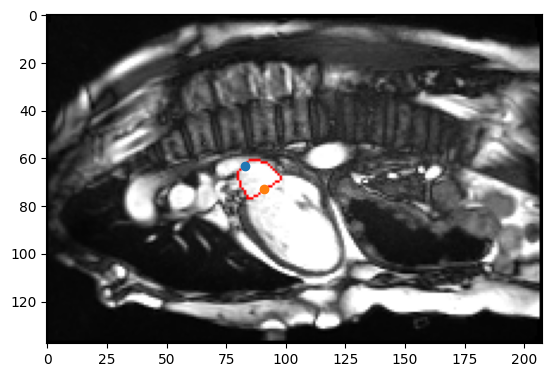

In [94]:
plt.figure()
img = cv2.convertScaleAbs(la_2ch[:, :, 0])
seg = seg_la_2ch[:, :, 0, 0]
overlay(img, seg)

In [66]:
landmark1 = lm['2ch'][0][0]
affine_inv = np.linalg.inv(nim_2ch.affine)

original_point = np.dot(affine_inv, np.append(landmark1[:2], [0,1]))
x_original, y_original, _, _ = original_point
print(x_original, y_original)

60.39750544242963 114.18811336641689


In [72]:
label = seg_la_2ch[:, :, 0, 0]
nim = nim_2ch
# Area per pixel
pixdim = nim.header['pixdim'][1:4]
area_per_pix = pixdim[0] * pixdim[1] * 1e-2  # Unit: cm^2

In [86]:
import sys
sys.path.append('../..')
from utils.image_utils import get_largest_cc
# Go through the label class
L = []
A = []
landmarks = []
labs = np.sort(list(set(np.unique(label)) - set([0])))
for i in labs:
    # The binary label map
    label_i = (label == i)

    # Get the largest component in case we have a bad segmentation
    label_i = get_largest_cc(label_i)

    # Go through all the points in the atrium, sort them by the distance along the long-axis.
    points_label = np.nonzero(label_i)
    points = []
    for j in range(len(points_label[0])):  # the number of points
        x = points_label[0][j]
        y = points_label[1][j]
        # here nim.affine is 4*4 dimensional and 
        # if j == 0:
            # print(np.array([x, y]))
            # print(np.dot(nim.affine, np.array([x, y, 0, 1]))[:3])
            # print(np.dot(np.dot(nim.affine, np.array([x, y, 0, 1]))[:3], long_axis))
        points += [[x, y,
                    np.dot(np.dot(nim.affine, np.array([x, y, 0, 1]))[:3], long_axis)]] 
    points = np.array(points)
    points = points[points[:, 2].argsort()]  # sort by the distance along the long-axis

    # The centre at the top part of the atrium (top third)
    n_points = len(points)
    top_points = points[int(2 * n_points / 3):]
    cx, cy, _ = np.mean(top_points, axis=0)

    # The centre at the bottom part of the atrium (bottom third)
    bottom_points = points[:int(n_points / 3)]
    bx, by, _ = np.mean(bottom_points, axis=0)

    # Determine the major axis by connecting the geometric centre and the bottom centre
    major_axis = np.array([cx - bx, cy - by])  # major_axis is a vector
    major_axis = major_axis / np.linalg.norm(major_axis)  # normalization

    # Get the intersection between the major axis and the atrium contour
    px = cx + major_axis[0] * 100  # after normalization, can directly multiply by 100
    py = cy + major_axis[1] * 100
    qx = cx - major_axis[0] * 100
    qy = cy - major_axis[1] * 100

    # Note the difference between nifti image index and cv2 image index
    # nifti image index: XY
    # cv2 image index: YX (height, width)
    image_line = np.zeros(label_i.shape)
    cv2.line(image_line, (int(qy), int(qx)), (int(py), int(px)), (1, 0, 0))
    image_line = label_i & (image_line > 0)

    # * Sort the intersection points by the distance along long-axis
    # and calculate the length of the intersection
    points_line = np.nonzero(image_line)
    points = []
    points_raw = []
    for j in range(len(points_line[0])):
        x = points_line[0][j]
        y = points_line[1][j]
        # World coordinate
        point = np.dot(nim.affine, np.array([x, y, 0, 1]))[:3]
        # Distance along the long-axis
        points += [np.append(np.append(point, np.dot(point, long_axis)), np.array([x,y]))]  #  (x,y,distance)
    points = np.array(points)
    points = points[points[:, 3].argsort(), :]  # sort by the distance along the long-axis
    L += [np.linalg.norm(points[-1] - points[0]) * 1e-1]  # Unit: cm

    # Calculate the area
    A += [np.sum(label_i) * area_per_pix]

    # Landmarks of the intersection points
    landmarks += [points[0]]
    landmarks += [points[-1]]

In [87]:
points[0]

array([-26.7430875 , -44.5572381 ,  57.69666807, -36.17476213,
        63.        ,  83.        ])

In [88]:
points[-1]

array([-39.65001318, -29.94030864,  44.76875634, -12.9858819 ,
        73.        ,  91.        ])